In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from random import choice, randint, seed

from pydrake.geometry.optimization import HPolyhedron
from pydrake.solvers import MosekSolver, GurobiSolver

from gcs.bezier import BezierGCS
from gcs.linear import LinearGCS
from models.maze import Maze

import os
os.environ["MOSEKLM_LICENSE_FILE"] = "/Users/nolan/mosek/mosek.lic"
MosekSolver.AcquireLicense()
print("Mosek is enabled: ", MosekSolver().enabled())
os.environ["GRB_LICENSE_FILE"] = "/Users/nolan/gurobi/gurobi.lic"
GurobiSolver.AcquireLicense()
print("Gurobi is enabled: ", GurobiSolver().enabled())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mosek is enabled:  True
Gurobi is enabled:  True


# Construction of the maze

In [3]:
seed(4)

maze_size = 50
knock_downs = 100

start = np.array([0.5, 0])
goal = np.array([maze_size - 0.5, maze_size])
maze = Maze(maze_size, maze_size)
maze.make_maze()

while knock_downs > 0:
    cell = maze.cell_at(randint(1, maze_size - 2), randint(1, maze_size - 2))
    walls = [w for w, up in cell.walls.items() if up]
    if len(walls) > 0:
        maze.knock_down_wall(cell, choice(walls))
        knock_downs -= 1

regions = []
edges = []
for x in range(maze_size):
    for y in range(maze_size):
        regions.append(HPolyhedron.MakeBox([x, y], [x+1., y+1.]))
        C = y + x * maze.ny
        if not maze.map[x][y].walls['N']:
            edges.append((C, C + 1))
        if not maze.map[x][y].walls['S']:
            edges.append((C, C - 1))
        if not maze.map[x][y].walls['E']:
            edges.append((C, C + maze.ny))
        if not maze.map[x][y].walls['W']:
            edges.append((C, C - maze.ny))

# Minimum-distance problem

In [4]:
def plot_maze():
    plt.figure(figsize=(5,5))
    plt.axis('equal')
    maze.plot(1)
    plt.plot(*start, 'kx', markersize=10)
    plt.plot(*goal, 'kx', markersize=10)

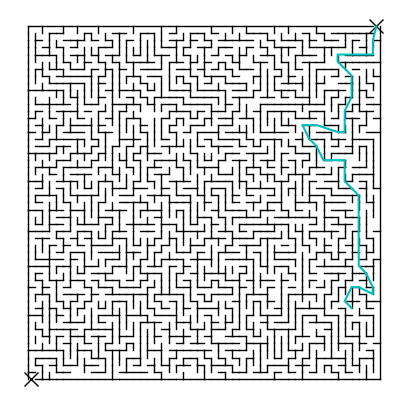

In [8]:
plot_maze()



plt.plot(x, y, "c-")
plt.show()

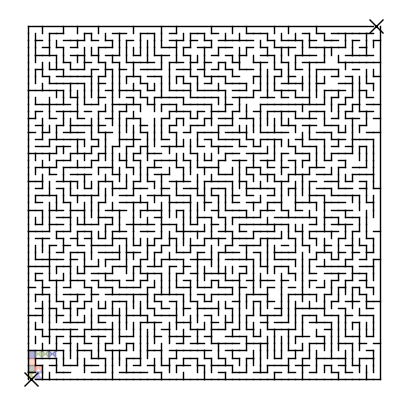

<Figure size 640x480 with 0 Axes>

In [15]:
plot_maze()
def DeserializeRegions(file_path):
    regions = []
    with open(file_path, 'r') as file:
        data = file.readline().split(',')
        num_regions = int(data[0])

        idx = 1
        for _ in range(num_regions):
            num_rows = int(data[idx])
            num_cols = int(data[idx + 1])
            idx += 2

            A = np.zeros((num_rows, num_cols))
            for i in range(num_rows):
                for j in range(num_cols):
                    A[i, j] = float(data[idx])
                    idx += 1

            b = np.zeros(num_rows)
            for i in range(num_rows):
                b[i] = float(data[idx])
                idx += 1

            regions.append(HPolyhedron(A, b))

    return regions

def ComputeVerticesOf(polyhedron):
    A, b = polyhedron.A(), polyhedron.b()
    n = A.shape[0]
    vertices = []
    for i in range(n-1):
        for j in range(i+1, n):
            a1, b1, c1 = A[i,0], A[i,1], -b[i]
            a2, b2, c2 = A[j,0], A[j,1], -b[j]
            if np.cross(A[i,:], A[j,:]) != 0:     # not parallel
                vertex = [ (b1*c2-b2*c1)/(a1*b2-a2*b1), (c1*a2-c2*a1)/(a1*b2-a2*b1) ]
                if (A @ vertex <= b).all(): vertices.append(vertex)     # indeed a vertex
    return VerticesToWellOrderedVertices(np.array(vertices))

def VerticesToWellOrderedVertices(vertices):
    return vertices[np.argsort(np.arctan2(vertices[:,1], vertices[:,0]))]

def RandomColorPicker():
    import random
    while True:
        color_picked = random.choice(list(mcolors.CSS4_COLORS.keys()))
        r, g, b = mcolors.to_rgb(color_picked)
        luminance = 0.299 * r + 0.587 * g + 0.114 * b
        if luminance < 0.7: return color_picked

def VisualizeRegions(regions, traj=None, alpha=0.3, sample_num=100):
    # plt.figure()
    for region in regions:
        vertices = ComputeVerticesOf(region)
        plt.fill(vertices[:,0], vertices[:,1], alpha=alpha, color=RandomColorPicker())
    if traj is not None:
        samples = np.linspace(traj.start_time(), traj.end_time(), sample_num)
        values = np.squeeze([traj.value(t) for t in samples])
        control_points = traj.control_points()
        x = [control_point[0] for control_point in control_points]
        y = [control_point[1] for control_point in control_points]
        plt.plot(x, y, "r*")
        # plt.plot(control_points[0,:], control_points[1,:], "r*")
        plt.plot(values[:,0], values[:,1], "c-")
    plt.show()
import matplotlib.colors as mcolors
VisualizeRegions(DeserializeRegions("maze_way_regions.csv"))
plt.savefig('bug_maze.pdf', bbox_inches='tight')

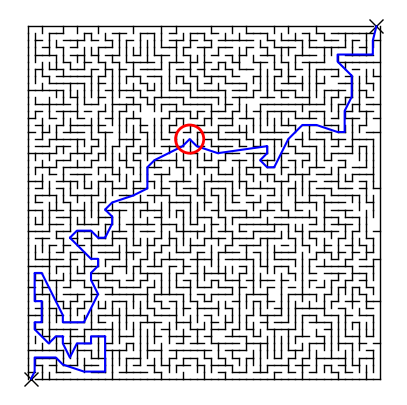

In [12]:
relaxation = True
gcs = LinearGCS(regions, edges)
gcs.addSourceTarget(start, goal)
gcs.setSolver(MosekSolver())
waypoints = gcs.SolvePath(relaxation)[0]

plot_maze()
def plot_circle():
    coll = PatchCollection([plt.Circle((23, 34), 2)], linewidth=2, fc='None', ec='r', zorder=3)
    plt.gca().add_collection(coll)
plot_circle()
plt.plot(*waypoints, 'b')
plt.savefig('maze_length.pdf', bbox_inches='tight')

# Minimum-time problem

In [6]:
qdot_min = -1
qdot_max = 1
velocity = np.zeros((2, 2))
order = 5
continuity = 2
hdot_min = 1e-1
regularizer = [1e-1, 1e-1]
st_edges = [[0], [-1]]

target = np.array([49.5, 50])
source = np.array([23.5, 34.5])
gcs = BezierGCS(regions, order, continuity, edges, hdot_min=hdot_min)
# gcs.setSolver(MosekSolver())
gcs.setSolver(GurobiSolver())
gcs.setPaperSolverOptions()
gcs.addTimeCost(1)
gcs.addPathLengthCost(1)
# gcs.addDerivativeRegularization(*regularizer, 2)
# gcs.addVelocityLimits([qdot_min] * 2, [qdot_max] * 2)
# gcs.addSourceTarget(start, goal, edges=st_edges, velocity=velocity)
import time
time_taken = 0
for _ in range(5):
    try:
        a = np.random.randint(0, 50)
        b = np.random.randint(0, 50)
        source = np.array([a, b])
        gcs.addSourceTarget(source, target)
        print(source)

        t_start = time.time()
        traj, result = gcs.SolvePath()[0]
        print(result.get_solver_id().name())
        t_end = time.time()
        t_taken = (t_end - t_start)
        print(t_taken)
        time_taken += t_taken
    except:
        continue
print(time_taken / 5)

[ 5 46]
[36  8]
[13 21]
[28 26]
[30 47]
0.0


In [45]:
print(f"time taken: {t_end - t_start}")

time taken: 90.27225399017334


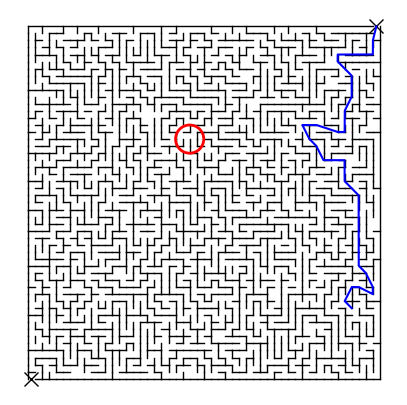

In [49]:
n_samples = 5000

times = np.linspace(traj.start_time(), traj.end_time(), n_samples)
waypoints = np.squeeze([traj.value(t) for t in times]).T

plot_maze()
plot_circle()
plt.plot(*waypoints, 'b')

plt.savefig('maze_time.pdf', bbox_inches='tight')